       对于分类任务的输出层，激活函数最好不要设置为relu(可以直接使用softmax)，因为对于小于0的输出其直接最小化为0，在交叉熵的计算中log(0)会出现问题，对于回归任务，可以完全不使用激活函数
       您可以尝试逐渐增加神经元的数量和隐层层数,直到网络开始过度拟合，来确定层数和神经元个数等超参数
       如果测试集的精度过低，则可能是模型过拟合造成的，可增加样本的数量和降低模型的复杂度

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib qt5

In [ ]:
'''简单的回归(一次函数)'''
x_data = np.random.rand(100).astype(np.float32)# tensorflow中的数据大多是float32
y_data = x_data * 0.1 + 0.3

weight = tf.Variable(tf.random_uniform([1], -1, 1))
biases = tf.Variable(tf.zeros([1]))

y = weight * x_data + biases

loss = tf.reduce_mean(tf.square(y_data-y)) # 意思是以mean的方式缩减tensor
optimizer = tf.train.GradientDescentOptimizer(0.5) # 0.5是学习率
train = optimizer.minimize(loss)

init = tf.global_variables_initializer() # 首先是绘制结构，然后运算

with tf.Session() as sess:
    sess.run(init)
    for step in range(200):
        sess.run(train)
        if step % 20 == 0:
            print(step, sess.run(weight), sess.run(biases))

In [ ]:
'''placeholder 先定义变量的形状，类型，run时赋值'''
a = [2]
b = [3]

input1 = tf.placeholder(tf.float32)
input2 = tf.placeholder(tf.float32)

output = tf.multiply(input1, input2)

with tf.Session() as sess:
    print(sess.run(output, feed_dict={input1: a, input2: b}))

In [ ]:
'''简单的回归例子(二次函数) + tensorboard可视化功能'''
'''name_scope  tf.summary.FileWriter是绘制结构图时用到的'''
'''tf.summary.histogram  tf.summary.scalar  tf.summary.merge_all绘制变量变化图时用到的'''
def add_layer(inputs, in_size, out_size, serial_num_layer, activation_function=None):
    layer_name = "layer%s" %serial_num_layer
    with tf.name_scope(layer_name):
        with tf.name_scope('weight'):
            weight = tf.Variable(tf.random_normal([in_size, out_size]), name='W')
            tf.summary.histogram(layer_name+'/weight', weight) #　W为一个矩阵，histogram以分布的形式可视化，tensorboard
        with tf.name_scope('biases'):
            biases = tf.Variable(tf.zeros([out_size, 1]), name='b')
            tf.summary.histogram(layer_name+'/biases', biases)#　W为一个矩阵，histogram以分布的形式可视化，tensorboard
        weight_t = tf.matrix_transpose(weight)
        with tf.name_scope('wtx_plus_b'):
            wtx_plus_b = tf.matmul(weight_t, inputs) + biases
        if activation_function == None:
            return wtx_plus_b
        else:
            return activation_function(wtx_plus_b)

x_data = np.linspace(-1, 1, 300).reshape(1, 300) #1个属性，300个样例
noise = np.random.normal(0, 0.05, size=x_data.shape)
y_data = np.square(x_data) - 0.5 + noise

tf.reset_default_graph()

plt.ion()# 可视化

with tf.name_scope('inputs'):
    xs = tf.placeholder(tf.float32, [1, None], name='x_input')
    ys = tf.placeholder(tf.float32, [1, None], name='y_input')

l1 = add_layer(xs, 1, 10, serial_num_layer=1, activation_function=tf.nn.relu)
prediction = add_layer(l1, 10, 1, serial_num_layer=2, activation_function=None)

with tf.name_scope('loss'):# 相当于是名称空间
    loss = tf.reduce_mean(tf.reduce_sum(tf.square(ys-prediction), reduction_indices=[0])) # 计算损失
    tf.summary.scalar('loss', loss) #scalar为以曲线的形式可视化，tensorboard
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) # 梯度下降
    
init = tf.global_variables_initializer()
with tf.Session() as sess:
    merged = tf.summary.merge_all() # tensorboard  在logs目录所在的位置打开终端，输入tensorboard --logdir=logs/
    writer = tf.summary.FileWriter('logs/', sess.graph) # 保存于logs文件夹。tensorboard write
    sess.run(init)
    for i in range(1000):
        sess.run(train_step, feed_dict={xs: x_data, ys: y_data})
        #可视化 start
        if i % 50 == 0:
            loss_value, result = sess.run([loss, merged], feed_dict={xs: x_data, ys: y_data}) # tensorboard
            writer.add_summary(result, i) # tensorboard
            plt.cla()
            print(loss_value)
            #print(sess.run(loss, feed_dict={xs: x_data, ys: y_data})) # 输出loss
            prediction_value = sess.run(prediction, feed_dict={xs: x_data})
            plt.scatter(x_data, prediction_value, c='r')
            plt.scatter(x_data, y_data, c='b', alpha=0.4)
            plt.pause(0.2)
        #可视化 end
plt.ioff()

In [ ]:
'''管理图谱'''
x1 = tf.Variable(1)
x1.graph is tf.get_default_graph() # 返回True，x1位于默认图谱中
graph = tf.Graph() # 创建以个新的图谱
with graph.as_default(): # 将新创建的图谱暂时设置为默认图谱
    x2 = tf.Variable(2)
x2.graph is tf.get_default_graph() # 返回false, x2位于新创建的graph图谱中
x2.graph is graph # 返回True

In [ ]:
# y_val, z_val = sess.run([y, z]) 可以进行这样的操作

In [ ]:
'''保存和恢复模型'''
# remember to define the same dtype and shape when restore
import tensorflow as tf
W = tf.Variable([[1, 2, 3], [3, 4, 5]], dtype=tf.float32, name="weight")
b = tf.Variable([[1, 2, 3]], dtype=tf.float32, name="biases")
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    save_path = saver.save(sess, "my_net/save_net.ckpt") # 保存在my_net文件夹下
    print("Save_path:", save_path)

In [ ]:
'''恢复模型'''
import tensorflow as tf
# restore variables #
# redefine the same shape and same dtype for your variable # 
# it will save the value of variable, you should redefine the structure of variable and network #
W = tf.Variable(tf.zeros([2, 3]), dtype=tf.float32, name="weight")
b = tf.Variable(tf.zeros([1, 3]), dtype=tf.float32, name="biases")
# not need initial step #
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "my_net/save_net.ckpt")
    print("weight:", W.eval())
    print("biases:", b.eval())

In [ ]:
#共享变量p224(sklearn和tensorflow机器学习实用指南)

0.36666667
0.3
0.46666667
0.36666667
0.36666667
0.7
0.7
0.7
0.73333335
0.8
0.8333333
0.9
0.96666664
0.96666664
0.96666664
0.96666664
0.96666664
0.96666664
0.96666664
0.96666664


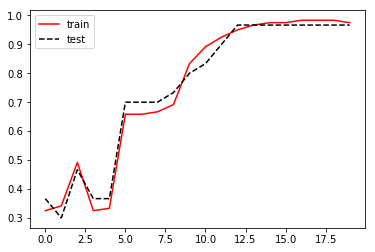

In [60]:
'''dropout随机失活, dropout添加在add_layer中'''
'''使用tensorflow的API来实现全连接和交叉熵'''
import numpy as np
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# load data start #
iris_data = load_iris()
x = iris_data.data
y = iris_data.target
y = LabelBinarizer().fit_transform(y) # 将label转换为onehot编码
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# load data end # 
N_SAMPLE = x_train.shape[0]
N_ATTRIBUTE = x_train.shape[1]
N_OUTPUT = 3
N_BATCH = 2 # 批次数
N_BATCH_SAMPLR = int(np.ceil(N_SAMPLE / N_BATCH)) # 每批样本的数目, ceil向上取整
KEEP_PROB = 0
#全连接层
#对于x，样本为数为行，属性数为列。
# y = xw + b
def add_layer(inputs, in_size, out_size, activation_function=None):
    weight = tf.Variable(tf.random_normal([in_size, out_size]) / 100)
    biases = tf.Variable(tf.zeros([1, out_size]))
    xw_plus_b = tf.matmul(inputs, weight) + biases
    xw_plus_b = tf.nn.dropout(xw_plus_b, rate=keep_prob)
    if activation_function == None:
        return xw_plus_b
    else:
        if activation_function == tf.nn.softmax:
            return activation_function(xw_plus_b, axis=1)
        else:
            return activation_function(xw_plus_b)

def compute_accuracy(v_xs, v_ys):
    global prediction
    y_pre = sess.run(prediction, feed_dict={xs: v_xs, keep_prob: KEEP_PROB})
    correct_prediction = tf.equal(tf.argmax(y_pre, 1), tf.argmax(v_ys, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    result = sess.run(accuracy, feed_dict={xs: v_xs, ys: v_ys, keep_prob: KEEP_PROB})
    return result
        
#placeholder
xs = tf.placeholder(tf.float32, [None, N_ATTRIBUTE])
ys = tf.placeholder(tf.float32, [None, N_OUTPUT])
keep_prob = tf.placeholder(tf.float32) # 随机失活dropout的参数

accuracy_array_train = [] # 保存cross_entropy(损失)用以绘制图像
accuracy_array_test = [] 

# layer # 
'''start 调用API的全连接层'''
'''对于w的初始化,使用具有标准差为2/√n。它将被随机初的截断的正态(高斯)分布truncated_normal(使用截断的正态分布而不是
常规正态分布确保不会有任何大的权重,这可能会减慢训练。).使用这个特定的标准差有助于算法的收敛速度更快'''
# layer1 = tf.contrib.layers.fully_connected(
#     xs, 20, activation_fn=tf.nn.relu, 
#     weights_initializer=tf.initializers.truncated_normal(stddev=2 / np.sqrt(N_SAMPLE)))
# '''注意输出层无激活函数'''
# prediction = tf.contrib.layers.fully_connected(
#     layer1, N_OUTPUT, activation_fn=None, 
#     weights_initializer=tf.initializers.truncated_normal(stddev=2 / np.sqrt(N_SAMPLE)))
# cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=ys, logits=prediction))
'''end 调用API的全连接层'''

'''没有调用API的全连接层  start'''
layer1 = add_layer(xs, N_ATTRIBUTE, 20, activation_function=tf.nn.relu)
prediction = add_layer(layer1, 20, N_OUTPUT, activation_function=tf.nn.softmax)

# loss
# 先sum在mean时除数为sum之后的个数， 如果只有mean则为所有数的个数
cross_entropy = tf.reduce_mean(-tf.reduce_sum(ys*tf.log(prediction), reduction_indices=1))
'''没有调用API的全连接层  end'''

train_step = tf.train.GradientDescentOptimizer(0.07).minimize(cross_entropy)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(200):
        batch_xs = x_train
        batch_ys = y_train
        sess.run(train_step, feed_dict={xs: batch_xs, ys: batch_ys, keep_prob: KEEP_PROB})
        if i % 10 == 0:
#             print(sess.run(cross_entropy, feed_dict={xs: batch_xs, ys: batch_ys, keep_prob: 0.3}))
            print(compute_accuracy(x_test, y_test))
            accuracy_array_train.append(compute_accuracy(x_train, y_train))
            accuracy_array_test.append(compute_accuracy(x_test, y_test))           
'''可视化cross_entropy'''
#cross_entropy_array = np.array(cross_entropy_array)
plot_x = np.arange(20)
plt.figure()
plt.plot(plot_x, accuracy_array_train, 'r-', label='train', )
plt.plot(plot_x, accuracy_array_test, 'k--', label='test',)
plt.legend(loc='best')
plt.show()

In [3]:
'''感知机，也成为线性阈值单元(LTU, linear threshold unit)。可以认为是一个神经元(activation function(wt*x+b))。当人
工神经网络有两个或多个隐含层时,称为深度神经网络(DNN)'''
import tensorflow as tf
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import tensorflow.contrib as tc

iris_data = load_iris()
X = iris_data.data[:, (2, 3)] # 花瓣长度，宽度
y = (iris_data.target == 0).astype(np.int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
'''使用tensorflow高级API训练MLP(多层感知机) (有点问题，某个函数已经被丢弃)'''
# fearture_columns = tc.feature_column(X_train)#infer_real_valued_columns_from_input(X_train)
# dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[256, 64], fearture_columns=fearture_columns)
# dnn_clf.fit(x=X_train, y=y_train, batch_size=50, steps=3)

TypeError: fully_connected() missing 2 required positional arguments: 'inputs' and 'num_outputs'

In [3]:
tf.layers.Dense()

TypeError: __init__() missing 1 required positional argument: 'units'